In [1]:

import torch
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
import os, sys
import copy

sys.path.append('../')

from models import (
    AE,
    IRAE    
)

from models.modules import (
    FC_vec,
)

from bezier import Bezier, demo2bezier, bezier2traj, bezier_Riemannian_metric

from utils.utils import label_to_color
from sklearn.mixture import GaussianMixture

device = f'cuda:0'

seed = 2023
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [2]:
traj = np.load('../datasets/poc/poc_for_bezier.npy')
x = torch.tensor(traj[0], dtype=torch.float32).unsqueeze(0)

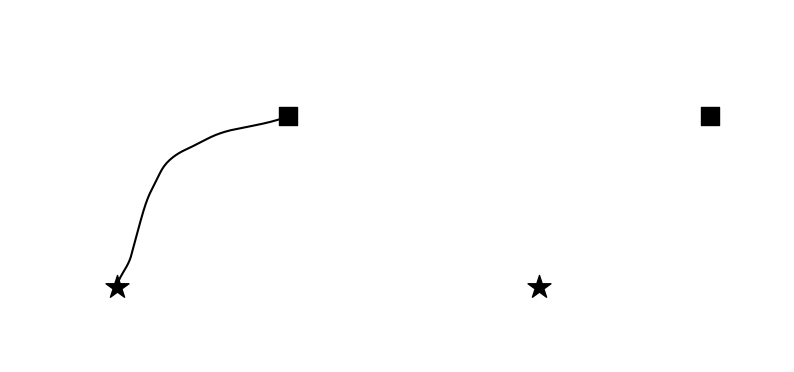

In [3]:
# Env setting
workspace = [[-1.8, 1.5], [-1.5, 1.8]]
init = [0.8, 0.8]
goal = [-0.8, -0.8]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in [0, 1]:
    axs[i].set_xlim(workspace[0])
    axs[i].set_ylim(workspace[1])
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].scatter(init[0], init[1], marker='s', s=150, c='k')
    axs[i].scatter(goal[0], goal[1], marker='*', s=300, c='k')
    

axs[0].plot(x[0, :, 0], x[0, :, 1], c='k')

plt.show()

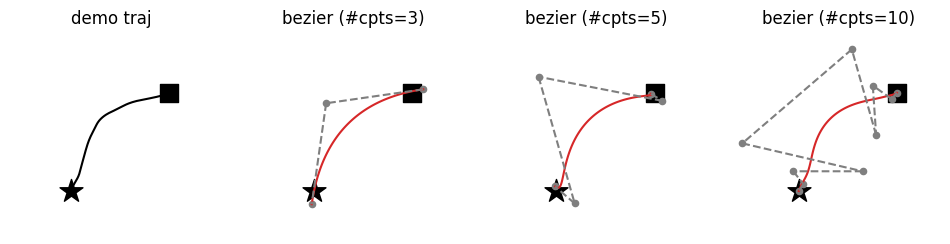

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in [0, 1, 2, 3]:
    axs[i].set_xlim(workspace[0])
    axs[i].set_ylim(workspace[1])
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].scatter(init[0], init[1], marker='s', s=150, c='k')
    axs[i].scatter(goal[0], goal[1], marker='*', s=300, c='k')
    

axs[0].plot(x[0, :, 0], x[0, :, 1], c='k')

for idx, nps in zip([1, 2, 3], [3, 5, 10]):
    bezier = Bezier(dof=2, T=1, num_control_points=nps)
    bezier.LfD(q_demo_traj=x, T=1)
    t = torch.linspace(0, 1, 100).view(1, 100)
    traj = bezier.curve(t)
    axs[idx].scatter(bezier.theta[0, :, 0], bezier.theta[0, :, 1], c='tab:gray', s=20)
    axs[idx].plot(traj[0, :, 0], traj[0, :, 1], c='tab:red')

    for start, end in zip(bezier.theta[0][:-1], bezier.theta[0][1:]):
        X = np.vstack([start, end])
        axs[idx].plot(X[:,0], X[:,1], c='tab:gray', linestyle='--')
        
axs[0].set_title('demo traj')
axs[1].set_title('bezier (#cpts=3)')
axs[2].set_title('bezier (#cpts=5)')
axs[3].set_title('bezier (#cpts=10)')

plt.show()

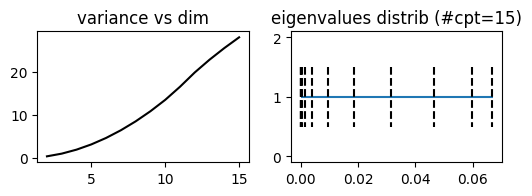

In [5]:
measures = []
fig, axs = plt.subplots(1, 2, figsize=(6, 1.7))
ranges = range(2, 16)
for nps in [i for i in ranges]:
    bezier = Bezier(dof=1, T=1, num_control_points=nps)
    bezier.set_Riemannian_metrics(num=1000)
    lambda_ = torch.linalg.eigh(bezier.H[0]).eigenvalues
    lambda_ = torch.clip(lambda_, min=1.0e-32)
    metric = ((torch.log(lambda_) - torch.log(lambda_).mean())**2).mean()
    measures.append(metric)
axs[0].plot(ranges, measures, c='k')

bezier = Bezier(dof=1, T=1, num_control_points=15)
bezier.set_Riemannian_metrics(num=100)   
lambda_ = torch.linalg.eigh(bezier.H[0]).eigenvalues
axs[1].hlines(1, 0, 0.067)
axs[1].eventplot(lambda_, orientation='horizontal', colors='k', linestyles='--')
axs[1].axis('on')

axs[0].set_title('variance vs dim')
axs[1].set_title('eigenvalues distrib (#cpt=15)')

plt.show()

In [6]:
bezier = Bezier(dof=2, T=1, num_control_points=10)
bezier.LfD(q_demo_traj=x, T=1)

eigh = torch.linalg.eigh(bezier.H[0])
S = eigh.eigenvalues
V = eigh.eigenvectors

In [7]:
min_dir = V[:, 0]
max_dir = V[:, -2]
min_dir[0] = 0
min_dir[-1] = 0
max_dir[0] = 0
max_dir[-1] = 0
max_dir = max_dir/max_dir.norm()
min_dir = min_dir/min_dir.norm()
step_size = 1

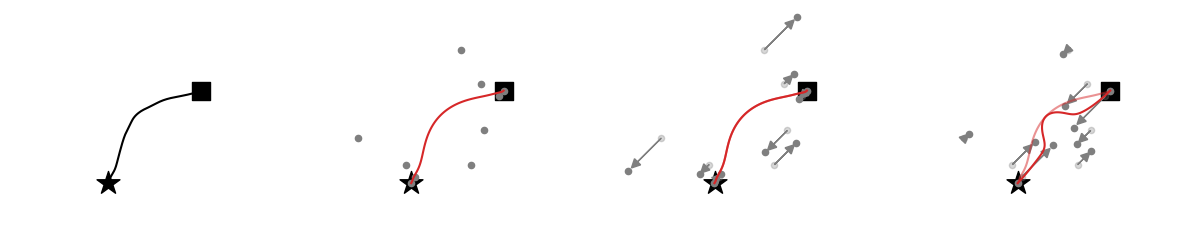

In [8]:
workspace = [[-2.5, 1.8], [-1.8, 2.2]]

fig, axs = plt.subplots(1, 4, figsize=(15, 3))
for i in [0, 1, 2, 3]:
    axs[i].set_xlim(workspace[0])
    axs[i].set_ylim(workspace[1])
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].scatter(init[0], init[1], marker='s', s=150, c='k')
    axs[i].scatter(goal[0], goal[1], marker='*', s=300, c='k')
    

axs[0].plot(x[0, :, 0], x[0, :, 1], c='k')

for idx, nps in zip([1, 2, 3], [10, 10, 10]):
    bezier = Bezier(dof=2, T=1, num_control_points=nps)
    bezier.LfD(q_demo_traj=x, T=1)
    t = torch.linspace(0, 1, 100).view(1, 100)
    traj = bezier.curve(t)
    if idx == 1:
        axs[idx].scatter(bezier.theta[0, :, 0], bezier.theta[0, :, 1], c='tab:gray', s=20)
        axs[idx].plot(traj[0, :, 0], traj[0, :, 1], c='tab:red')
        # for start, end in zip(bezier.theta[0][:-1], bezier.theta[0][1:]):
        #     X = np.vstack([start, end])
        #     axs[idx].plot(X[:,0], X[:,1], c='tab:gray', linestyle='--')
    else:
        axs[idx].scatter(bezier.theta[0, :, 0], bezier.theta[0, :, 1], c='tab:gray', s=20, alpha=0.3)
        axs[idx].plot(traj[0, :, 0], traj[0, :, 1], c='tab:red', alpha=0.5)
        if idx == 2:
            prev_theta = copy.deepcopy(bezier.theta[0, :])
            curr_theta = prev_theta + step_size*min_dir.reshape(-1, 1) 
            bezier.theta[0, :] = curr_theta
            axs[idx].scatter(bezier.theta[0, :, 0], bezier.theta[0, :, 1], c='tab:gray', s=20)
            traj = bezier.curve(t)
            axs[idx].plot(traj[0, :, 0], traj[0, :, 1], c='tab:red')
            for start, end in zip(prev_theta, curr_theta):
                axs[idx].arrow(
                    start[0], 
                    start[1], 
                    0.9*(end[0]-start[0]), 
                    0.9*(end[1]-start[1]), 
                    head_width=0.15, 
                    head_length=0.15, 
                    color='tab:gray', 
                    length_includes_head=True)
            
        elif idx == 3:
            prev_theta = copy.deepcopy(bezier.theta[0, :])
            curr_theta = prev_theta + step_size*max_dir.reshape(-1, 1) 
            bezier.theta[0, :] = curr_theta
            axs[idx].scatter(bezier.theta[0, :, 0], bezier.theta[0, :, 1], c='tab:gray', s=20)
            traj = bezier.curve(t)
            axs[idx].plot(traj[0, :, 0], traj[0, :, 1], c='tab:red')
            for start, end in zip(prev_theta, curr_theta):
                axs[idx].arrow(
                    start[0], 
                    start[1], 
                    0.9*(end[0]-start[0]), 
                    0.9*(end[1]-start[1]), 
                    head_width=0.15, 
                    head_length=0.15, 
                    color='tab:gray', 
                    length_includes_head=True)

plt.show()

In [9]:
bezier = Bezier(dof=2, T=1, num_control_points=nps)
bezier.LfD(q_demo_traj=x, T=1)
bezier.set_Riemannian_metrics(num=1000)
H = bezier.H[0]
# H = H[1:-1, 1:-1]
eigh = torch.linalg.eigh(H)
S = eigh.eigenvalues
V = eigh.eigenvectors

In [10]:
V_normalized = V/torch.sqrt(torch.einsum('ni, ij, nj -> n', V, H, V)).view(-1, 1)
V_normalized.size()

torch.Size([10, 10])

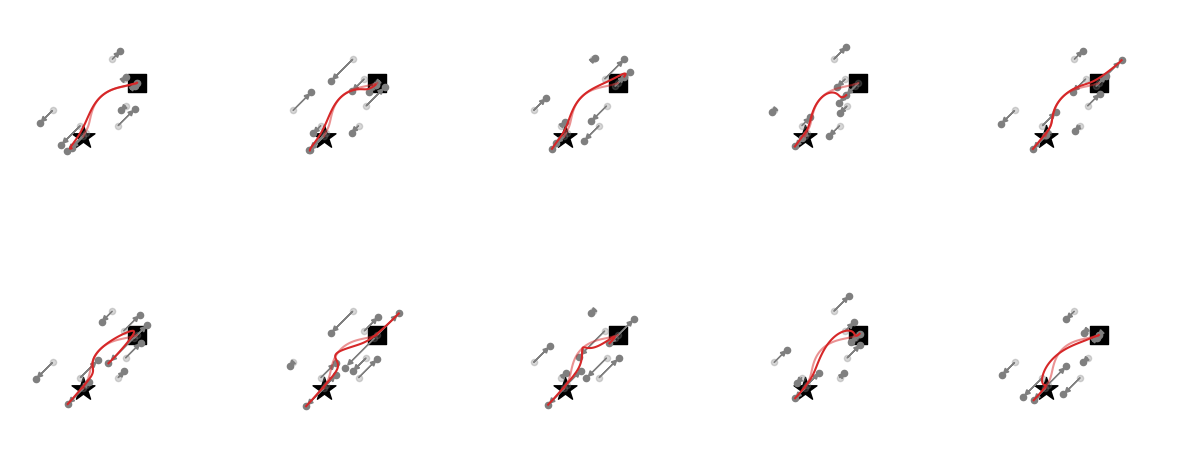

In [11]:
workspace = [[-3, 3], [-3, 3]]
step_size = 0.2

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
        axs[i,j].set_xlim(workspace[0])
        axs[i,j].set_ylim(workspace[1])
        axs[i,j].set_aspect('equal')
        axs[i,j].axis('off')
        axs[i,j].scatter(init[0], init[1], marker='s', s=150, c='k')
        axs[i,j].scatter(goal[0], goal[1], marker='*', s=300, c='k')
    
bezier = Bezier(dof=2, T=1, num_control_points=nps)
bezier.LfD(q_demo_traj=x, T=1)
t = torch.linspace(0, 1, 100).view(1, 100)
traj = bezier.curve(t)
prev_theta = copy.deepcopy(bezier.theta[0, :])

for i in range(2):
    for j in range(5):
        axs[i,j].scatter(prev_theta[:, 0], prev_theta[:, 1], c='tab:gray', s=20, alpha=0.3)
        axs[i,j].plot(traj[0, :, 0], traj[0, :, 1], c='tab:red', alpha=0.5)
        
        # curr_theta[0] = copy.deepcopy(prev_theta[0])
        # curr_theta[-1] = copy.deepcopy(prev_theta[-1])
        # curr_theta[1:-1] = copy.deepcopy(prev_theta[1:-1]) + step_size*V_normalized[4*i+j].reshape(-1, 1) 
        curr_theta = copy.deepcopy(prev_theta) + step_size*V_normalized[5*i+j].reshape(-1, 1) 
        bezier.theta[0, :] = curr_theta
        axs[i,j].scatter(bezier.theta[0, :, 0], bezier.theta[0, :, 1], c='tab:gray', s=20)
        traj2 = bezier.curve(t)
        axs[i,j].plot(traj2[0, :, 0], traj2[0, :, 1], c='tab:red')
        for start, end in zip(prev_theta, curr_theta):
            axs[i,j].arrow(
                start[0], 
                start[1], 
                0.9*(end[0]-start[0]), 
                0.9*(end[1]-start[1]), 
                head_width=0.15, 
                head_length=0.15, 
                color='tab:gray', 
                length_includes_head=True)
plt.show()